In [1]:
import logging
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from scipy.optimize import leastsq

In [2]:
def _gaussian_function_2d(peak_height, center_y, center_x, width_y, width_x):
    """Returns a 2D Gaussian function

    Parameters
    ----------
    peak_height :
        peak of distribution
    center_y :
        y-coordinate of distribution center
    center_x :
        x-coordinate of distribution center
    width_y :
        width of distribution along x-axis
    width_x :
        width of distribution along y-axis

    Returns
    -------
    f(x,y) : function
        Returns the value of the distribution at a
        particular x,y coordinate

    """

    return lambda y, x:  peak_height * np.exp(
        -(((center_y - y) / width_y) ** 2 + ((center_x - x) / width_x) ** 2)
        / 2
    )



def rf_guassian(dim_y, dim_x, peak_height, center_y, center_x, width_y, width_x):
    """Returns a RF matrix based on 2D Gaussian function

    Parameters
    ----------
    dim_y :
        length of y-position 
    dim_x :
        length of x-position 
    
    peak_height :
        peak of distribution
    center_y :
        y-coordinate of distribution center
    center_x :
        x-coordinate of distribution center
    width_y :
        width of distribution along x-axis
    width_x :
        width of distribution along y-axis

    Returns
    -------
    rf_matrix : RF matrix
     
    """
    f=_gaussian_function_2d(peak_height, center_y, center_x, width_y, width_x)
    rf_matrix=np.zeros((dim_y,dim_x))
    for i in range(dim_y):
        for j in range(dim_x):
            rf_matrix[i,j]=f(y=i,x=j)

    return rf_matrix





def gaussian_moments_2d(data):
    """Finds the moments of a 2D Gaussian distribution,
    given an input matrix

    Parameters
    ----------
    data : numpy.ndarray
        2D matrix

    Returns
    -------
    baseline:
        baseline of data
    peak_height :
        peak of distribution
    center_y :
        y-coordinate of distribution center
    center_x :
        x-coordinate of distribution center
    width_y :
        width of distribution along x-axis
    width_x :
        width of distribution along y-axis
    """
    
    total = data.sum()
    height = data.max()

    Y, X = np.indices(data.shape)
    center_y = (Y * data).sum() / total
    center_x = (X * data).sum() / total

    if (
        np.isnan(center_y)
        or np.isinf(center_y)
        or np.isnan(center_x)
        or np.isinf(center_x)
    ):
        return None

    col = data[:, int(center_x)]
    row = data[int(center_y), :]

    width_y = np.sqrt(
        np.abs((np.arange(row.size) - center_y) ** 2 * row).sum() / row.sum()
    )
    width_x = np.sqrt(
        np.abs((np.arange(col.size) - center_x) ** 2 * col).sum() / col.sum()
    )

    return height, center_y, center_x, width_y, width_x


def fit_2d_gaussian(matrix):
    """Fits a receptive field with a 2-dimensional Gaussian
    distribution

    Parameters
    ----------
    matrix : numpy.ndarray
        2D matrix of spike counts

    Returns
    -------
    parameters - tuple
        peak_height : peak of distribution
        center_y : y-coordinate of distribution center
        center_x : x-coordinate of distribution center
        width_y : width of distribution along x-axis
        width_x : width of distribution along y-axis
        rsq :     r-square value of fitting
    success - bool
        True if a fit was found, False otherwise
    """
    

    params = gaussian_moments_2d(abs(matrix))
    if params is None:
        return (np.nan, np.nan, np.nan, np.nan, np.nan), False

    def errorfunction(p):
        return np.ravel(
            _gaussian_function_2d(*p)(*np.indices(matrix.shape)) - matrix
        )

    fit_params, ier = leastsq(errorfunction, params)
    success = True if ier < 5 else False

    RSS=(errorfunction(fit_params)**2).sum()
    TSS=((matrix-np.mean(matrix))**2).sum()
    rsq=1-RSS/TSS
    
    return rsq, fit_params, success



def fit_2d_gaussian_stats(matrix,nShuffle=1000):
    """Compute empirical p-value of fiting a receptive field with a 2-dimensional Gaussian
    distribution

    Parameters
    ----------
    matrix : numpy.ndarray
        2D matrix of spike counts
    nShuffle: number of shuffles    

    Returns
    -------
    p_value: empirical p-value of rsq
    
    parameters - tuple
        peak_height : peak of distribution
        center_y : y-coordinate of distribution center
        center_x : x-coordinate of distribution center
        width_y : width of distribution along x-axis
        width_x : width of distribution along y-axis
        rsq :     r-square value of fitting
    success - bool
        True if a fit was found, False otherwise
    """
    
    rsq, fit_params, success = fit_2d_gaussian(matrix)
    
    length_1=len(matrix[:,0])
    length_2=len(matrix[0,:])
    
    shuffle_rsq=np.zeros(nShuffle)
    for i_shuffle in range(nShuffle):
        temp_matrix_1=matrix.reshape((length_1*length_2,1))
        temp_matrix_2=np.random.permutation(temp_matrix_1)
        temp_matrix_3=temp_matrix_2.reshape((length_1,length_2))

        temp_rsq, temp_fit_params, temp_success = fit_2d_gaussian(temp_matrix_3)
        shuffle_rsq[i_shuffle]=temp_rsq
    
    samples=len(np.argwhere(shuffle_rsq>rsq))
    p_value= (samples+1)/(nShuffle)
    
    return p_value, rsq, fit_params
    



def is_rf_inverted(rf_thresh):
    """Checks if the receptive field mapping timulus is suppressing
    or exciting the cell

    Parameters
    ----------
    rf_thresh : matrix
        matrix of spike counts at each stimulus position

    Returns
    -------
    if_rf_inverted : bool
        True if the receptive field is inverted
    """
    edge_mask = np.zeros(rf_thresh.shape)

    edge_mask[:, 0] = 1
    edge_mask[:, -1] = 1
    edge_mask[0, :] = 1
    edge_mask[-1, :] = 1

    num_edge_pixels = np.sum(rf_thresh * edge_mask)

    return num_edge_pixels > np.sum(edge_mask) / 2


def invert_rf(rf):
    """Creates an inverted version of the receptive field

    Parameters
    ----------
    rf - matrix of spike counts at each stimulus position

    Returns
    -------
    rf_inverted - new RF matrix

    """
    return np.max(rf) - rf


def threshold_rf(rf, threshold):
    """Creates a spatial mask based on the receptive field peak
    and returns the x, y coordinates of the center of mass,
    as well as the area.

    Parameters
    ----------
    rf : numpy.ndarray
        2D matrix of spike counts
    threshold : float
        Threshold as ratio of the RF's standard deviation

    Returns
    -------
    threshold_rf : numpy.ndarray
        Thresholded version of the original RF
    center_x : float
        x-coordinate of mask center of mass
    center_y : float
        y-coordinate of mask center of mass
    area : float
        area of mask
    """
    rf_filt = ndi.gaussian_filter(rf, 1)

    threshold_value = np.max(rf_filt) - np.std(rf_filt) * threshold

    rf_thresh = np.zeros(rf.shape, dtype="bool")
    rf_thresh[rf_filt > threshold_value] = True

    labels, num_features = ndi.label(rf_thresh)

    best_label = np.argmax(
        ndi.maximum(rf_filt, labels=labels, index=np.unique(labels))
    )

    labels[labels != best_label] = 0
    labels[labels > 0] = 1

    center_y, center_x = ndi.measurements.center_of_mass(labels)
    area = float(np.sum(labels))

    return labels, np.around(center_x, 4), np.around(center_y, 4), area


def rf_on_screen(rf, center_y, center_x):
    """Checks whether the receptive field is on the screen, given the
    center location."""
    return 0 < center_y < rf.shape[0] and 0 < center_x < rf.shape[1]


def convert_elevation_to_degrees(
    elevation_in_pixels, elevation_offset_degrees=-30
):
    """Converts a pixel-based elevation into degrees relative to
    center of gaze

    The receptive field computed by this class is oriented such
    that the pixel values are in the correct relative location
    when using matplotlib.pyplot.imshow(), which places (0,0)
    in the upper-left corner of the figure.

    Therefore, we need to invert the elevation value prior
    to converting to degrees.

    Parameters
    ----------
    elevation_in_pixels : float
    elevation_offset_degrees: float

    Returns
    -------
    elevation_in_degrees : float
    """
    elevation_in_degrees = (
        convert_pixels_to_degrees(8 - elevation_in_pixels)
        + elevation_offset_degrees
    )

    return elevation_in_degrees


def convert_azimuth_to_degrees(azimuth_in_pixels, azimuth_offset_degrees=10):
    """Converts a pixel-based azimuth into degrees relative
    to center of gaze

    Parameters
    ----------
    azimuth_in_pixels : float
    azimuth_offset_degrees: float

    Returns
    -------
    azimuth_in_degrees : float
    """
    azimuth_in_degrees = (
        convert_pixels_to_degrees((azimuth_in_pixels)) + azimuth_offset_degrees
    )

    return azimuth_in_degrees


def convert_pixels_to_degrees(value_in_pixels, degrees_to_pixels_ratio=10):
    """Converts a pixel-based distance into degrees

    Parameters
    ----------
    value_in_pixels : float
    degrees_to_pixels_ratio: float

    Returns
    -------
    value in degrees : float
    """
    return value_in_pixels * degrees_to_pixels_ratio


In [3]:
# Load RF data (on), select region: VISP
from pathlib import Path
DATA_PATH = Path('/Users/gaelle/Downloads')

rf_on=np.load(DATA_PATH.joinpath('BWM_rf_on.npy'))
rf_beryl_label=np.load(DATA_PATH.joinpath('BWM_rf_beryl_label.npy'))
vis_ind=np.argwhere(rf_beryl_label==385)[:,0]
rf_vis=rf_on[vis_ind,:,:]

In [4]:
####### Example 1: significant RF ##########

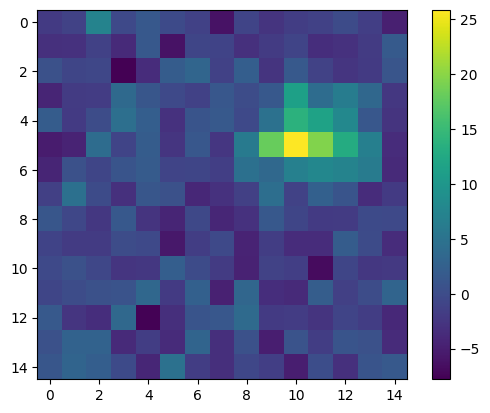

In [5]:
######## Compute z-scroe of RF:
rf_z= rf_vis[106,:,:]-np.mean(rf_vis[106,:,:])


####### plot RF ##########
plt.imshow(rf_z)
plt.colorbar()

In [6]:
####### Compute p-value, Rsq value, and fitting parameters of 2D guassian ##########
p_value, rsq, fit_params=fit_2d_gaussian_stats(rf_z,nShuffle=1000)

/Users/gaelle/anaconda3/envs/iblenv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


In [7]:
# p-value 
p_value

0.001

In [8]:
# R-square value 
rsq

0.5625712576099198

In [9]:
#  fitting parameters: peak_height, center_y, center_x, width_y, width_x 
fit_params

array([24.06780504,  4.83560032, 10.41318107, -0.88336625,  1.38241058])

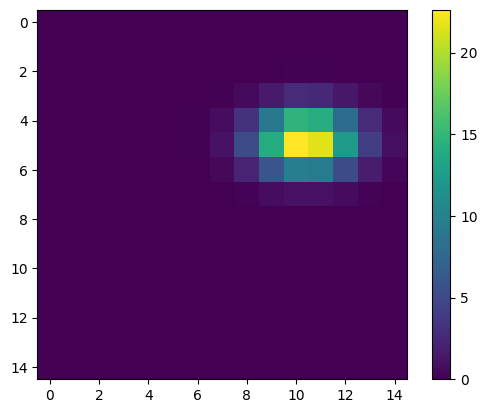

In [10]:
####### plot fitted RF based on fitting parameters of 2D gaussian ##########
length_y=len(rf_z[:,0])
length_x=len(rf_z[0,:])

rf_fit=rf_guassian(length_y, length_x, fit_params[0], fit_params[1], fit_params[2], fit_params[3], fit_params[4])

####### plot RF ##########
plt.imshow(rf_fit)
plt.colorbar()

In [11]:
####### Example 1: insignificant RF ##########

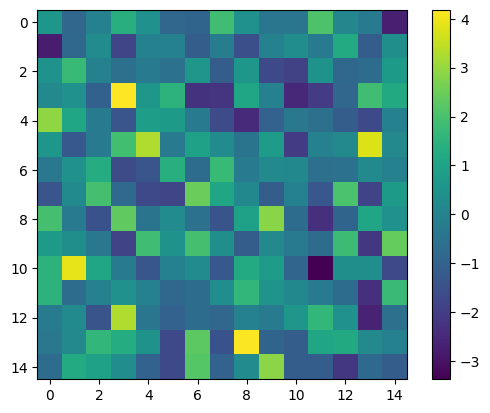

In [12]:
######## Compute z-scroe of RF:
rf_z= rf_vis[108,:,:]-np.mean(rf_vis[108,:,:])


####### plot RF ##########
plt.imshow(rf_z)
plt.colorbar()

In [13]:
####### Compute p-value, Rsq value, and fitting parameters of 2D guassian ##########
p_value, rsq, fit_params=fit_2d_gaussian_stats(rf_z,nShuffle=1000)

In [14]:
# p-value 
p_value

0.854

In [15]:
# R-square value 
rsq

0.01381862262034228

In [16]:
#  fitting parameters: peak_height, center_y, center_x, width_y, width_x 
fit_params

array([ 2.40647432,  9.0003651 , 13.99999986,  0.10337   ,  0.06264482])

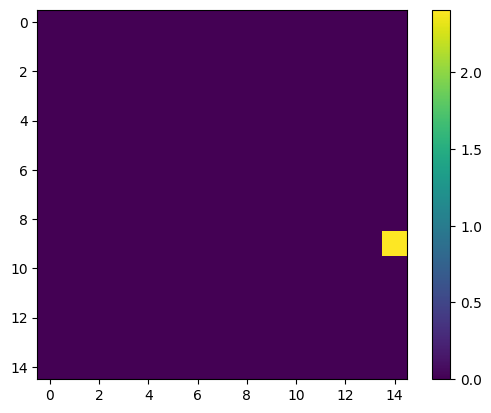

In [17]:
####### plot fitted RF based on fitting parameters of 2D gaussian ##########
length_y=len(rf_z[:,0])
length_x=len(rf_z[0,:])

rf_fit=rf_guassian(length_y, length_x, fit_params[0], fit_params[1], fit_params[2], fit_params[3], fit_params[4])

####### plot RF ##########
plt.imshow(rf_fit)
plt.colorbar()